## Bachelor Thesis - Informatik

### Variante 1 :
### Klassisches Neuronales Netz mit Fully Connected (Dense) Layern

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage die folgenden drei Datensätze :

#### ☑️ Ein eigener Datensatz der aus selbst aufgezeichneten Gesten eines Myo-Armbands besteht

#### ☑️ Ein Datensatz der bei Kaggle zur Verfügung steht

#### ☑️ Ein Datensatz der aus dem Ninapro DB5 Datensatz abgeleitet wurde

##### ▶️ Installation notwendiger Python-Bibliotheken

In [ ]:
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install matplotlib.pyplot
#%pip install scikit-learn
#%pip install tensorflow

#### ▶️ Importieren notwendiger Python-Bibliotheken

In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore

import tensorflow as tf # type: ignore

#### ▶️ Alternative 1: Einlesen der eigenen Roh-Daten aus dem Quellordner

In [ ]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Ruheposition
# Label 1 --> Daumen hoch
# Label 2 --> Zeige- und Mittelfinger gestreckt
# Label 3 --> Daumen, Zeige- und Mittelfinger gestreckt
# Label 4 --> Daumen gekrümmt in Richtung kleiner Finger
# Label 5 --> Alle Finger ausgestreckt
# Label 6 --> Finger zur Faust geballt


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
single_data = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['0', '1', '2', '3', '4', '5', '6']:
    single_data.append(pd.read_csv('./Eigene/P0L' + label + '.csv', sep=';', header=None))    
    single_data[int(label)][64] = int(label)



##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([df for df in single_data], axis=0).reset_index(drop=True)
all_data = all_data.dropna()

all_data.head()
single_data[0]

#### ▶️ Alternative 2: Einlesen des Datensatz EMG-4 von Kaggle aus dem Quellordner

[https://www.kaggle.com/code/akshita72/hand-gesture-recognition-from-emg-signals/input]

In [ ]:
# Die Dateien im Ordner "Kaggle" enthalten Auszüge aus dem originalen Datensatz
# Dieser wird unverändert übernommen


# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema:
# Label 0 --> Stein
# Label 1 --> Schere
# Label 2 --> Papier
# Label 3 --> OK-Zeichen


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
single_data = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['0', '1', '2', '3', ]:
    single_data.append(pd.read_csv('./Kaggle/' + label + '.csv', sep=',', header=None))        


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([df for df in single_data], axis=0).reset_index(drop=True)

##### ▶️ Alternative 3 : Einlesen von Daten aus dem Ninapro DB5 Datensatz<br>
****
📌 Dieses Feld ausführen bei Verwendung Ninapro-Daten !!

[Link zum Datensatz](https://ninapro.hevs.ch/instructions/DB5.html)

In [71]:
# Die Dateien im Ordner "Ninapro_DB5" enthalten Auszüge aus dem originalen Datensatz
# Aus den Matlab-Files wurden die 8 Sensorwerte und die zugehörigen Labels entnommen
# Es wurden nur die "Subjects" 01 bis 06 berücksichtigt

# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Ruheposition
# Label 1 --> Daumen hoch
# Label 2 --> Zeige- und Mittelfinger gestreckt
# Label 3 --> Daumen, Zeige- und Mittelfinger gestreckt
# Label 4 --> Daumen gekrümmt in Richtung kleiner Finger
# Label 5 --> Alle Finger ausgestreckt
# Label 6 --> Finger zur Faust geballt

##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
single_data = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['1', '2', '3', '4', '5', '6']:
    single_data.append(pd.read_csv('./Ninapro_DB5/P' + label + '.csv', sep=';', header=None))    
    

##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([df for df in single_data], axis=0).reset_index(drop=True)

all_data.tail()

,0,1,2,3,4,5,6,7,8
567995,-1,1,-2,-1,-1,0,0,3,0
567996,-2,2,-2,-3,-1,-3,-3,-2,0
567997,-3,-5,-3,-1,0,0,-2,3,0
567998,-5,0,0,-2,-1,-1,0,-3,0
567999,-1,-5,0,-1,0,0,0,-1,0


#### ▶️ Daten normalisieren

In [72]:
##############################################################
# Datenskalierung mit Min-/Max Prinzip oder Z-Score          #
##############################################################  
#sc = MinMaxScaler()
sc = StandardScaler()


##############################################################
# Normalisiere den Datensatz                                 #
##############################################################  
X = all_data.drop(8, axis=1).copy()
#X = all_data.drop(64, axis=1).copy()
X = sc.fit_transform(X)
X = np.array(X)

##############################################################
# Labels extrahieren aus Datensatz                           #
##############################################################  
#y = all_data[8].copy()
y = all_data[all_data.columns[-1]]
y = np.array(y)

##############################################################
# Vektorformen ausgeben                                      #
##############################################################  
print(X.shape)
print(y.shape)

(568000, 8)
(568000,)



#### ▶️ Datensatz aufteilen in Training- und Test-Daten

In [73]:
##############################################################
# Einkommentieren für eigene Daten                           #
# Klassen entsprechen der vorhandenen Gesten                 #
##############################################################
#num_classes = 7


##############################################################
# Einkommentieren für den Kaggle-Datensatz                   #
# Fixwert 4                                                  #
##############################################################
#num_classes = 4


##############################################################
# Einkommentieren für den Ninapro-Datensatz                  #
# Fixwert 7                                                  #
##############################################################
num_classes = 7

##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 100)


##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("X_train Vectorform:", X_train.shape)
print("X_test Vectorform:", X_test.shape)
print("y_train Vectorform:", y_train.shape)
print("y_test Vectorform:", y_test.shape)
print()
print(X.shape[0], "Gesamtwerte")
print(X_train.shape[0], "Trainingswerte")
print(X_test.shape[0], "Testwerte")


X_train Vectorform: (340800, 8)
X_test Vectorform: (227200, 8)
y_train Vectorform: (340800,)
y_test Vectorform: (227200,)

568000 Gesamtwerte
340800 Trainingswerte
227200 Testwerte


#### ▶️ Machine-Learning Modell erstellen

In [78]:
import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras import layers # type: ignore
from keras import ops # type: ignore

##############################################################
# Hyperparameter                                             #
##############################################################
#batch_size = 64
#epochs = 100


batch_size = 1000
epochs = 20

initializer='glorot_uniform'
#initializer='glorot_normal'
#initializer='he_uniform'
#initializer='he_normal'
#initializer='lecun_uniform'
#initializer='lecun_normal'
#initializer='ones'
#initializer='zeros'


#padding='valid'
padding='same'
# Format der Eingabedaten festlegen
input_shape = (X.shape[1],)


# Modell schichtweise erstellen
model = keras.Sequential()
model.add(layers.InputLayer(input_shape, kernel_initializer=initializer))
model.add(layers.Dense(512, activation='elu'))
model.add(layers.Dense(256, activation='elu'))
model.add(layers.Dense(num_classes,activation='softmax'))

# Modellparameter ausgeben
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,735 (538.03 KB)

 Trainable params: 137,735 (538.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

### ▶️ Ausgabe der Kostenfunktion für Training und Validation

In [49]:
# Ausgeben der verfügbaren Metriken 
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


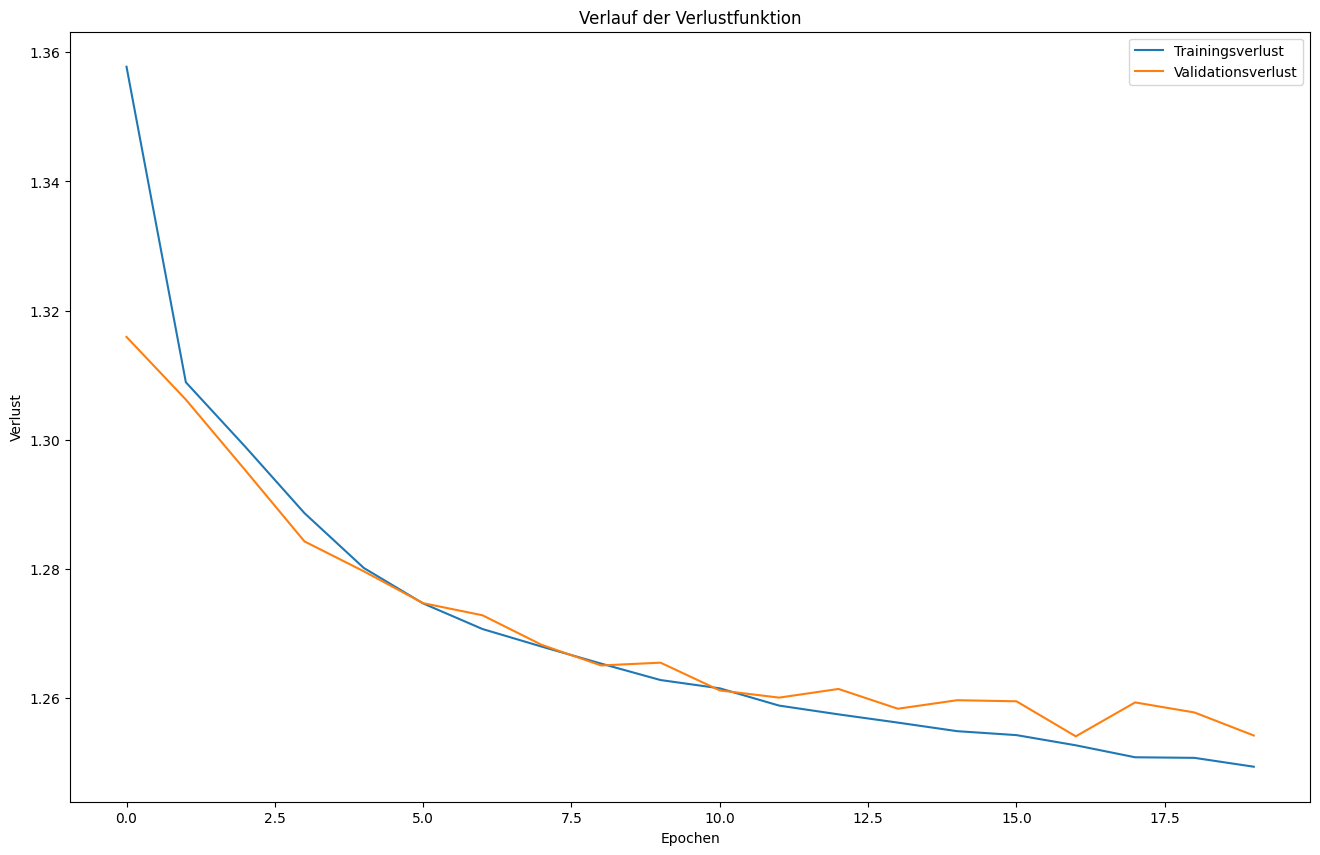

In [80]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['loss'], label="Trainingsverlust")
plt.plot(range(epochs), history.history['val_loss'], label="Validationsverlust")

plt.xlabel("Epochen")
plt.ylabel("Verlust")
plt.legend()
plt.title("Verlauf der Verlustfunktion")

plt.show()

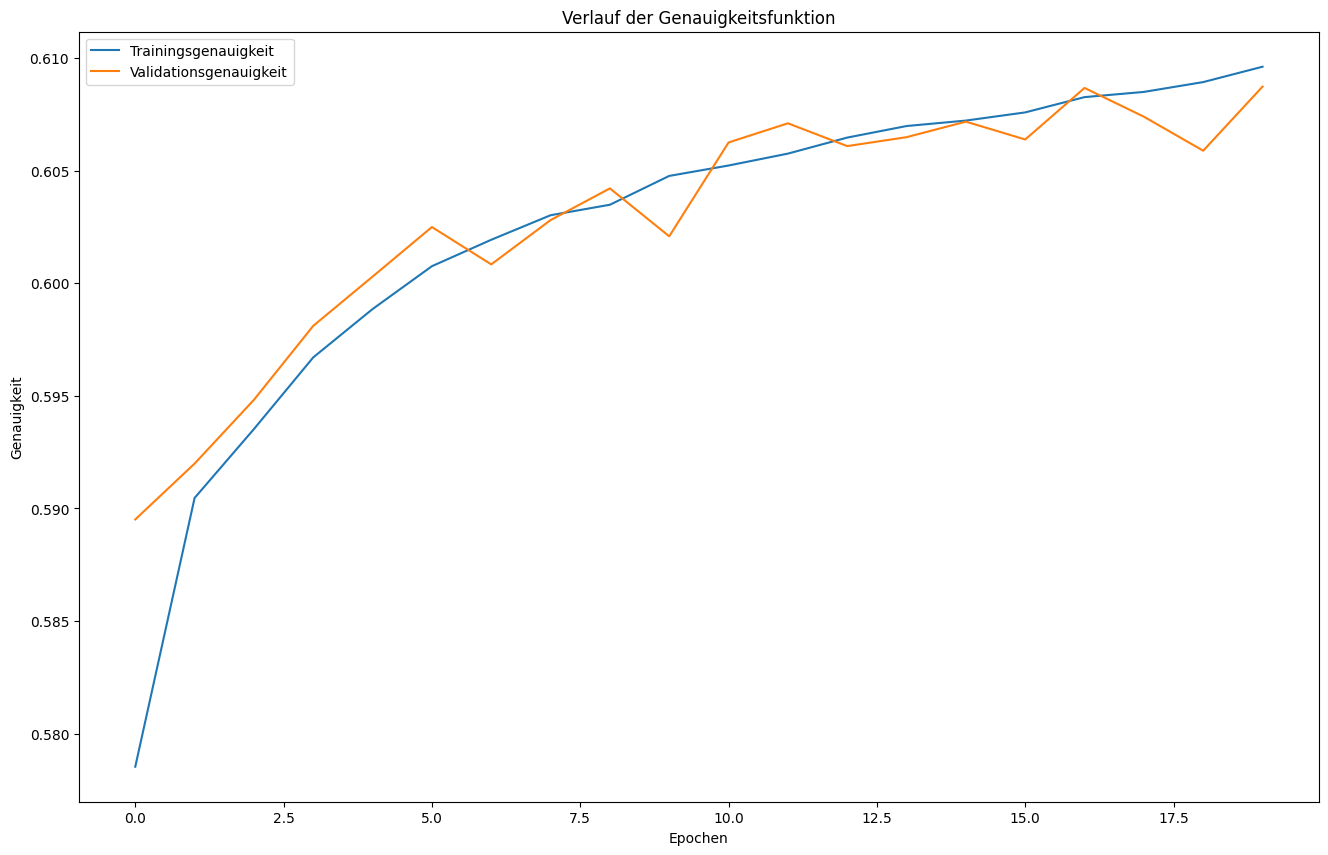

In [81]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['accuracy'], label="Trainingsgenauigkeit")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validationsgenauigkeit")

plt.xlabel("Epochen")
plt.ylabel("Genauigkeit")
plt.legend()
plt.title("Verlauf der Genauigkeitsfunktion")

plt.show()

### ▶️ Modell auf Testdaten anwenden und evaluieren

In [82]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.2544430494308472
Test accuracy: 0.6080149412155151


In [83]:
y = model.predict(np.array(X))[6000]
print(X[2390])
print(np.argmax(y))


17750/17750 ━━━━━━━━━━━━━━━━━━━━ 15s 840us/step
[ 5.40849865  2.65994552  1.37830443  0.98126466  0.3668397   0.13754907
  0.26627206 -1.0395752 ]
1


### ▶️ Metriken zur Beurteilung der Modellqualität 

7100/7100 ━━━━━━━━━━━━━━━━━━━━ 6s 867us/step


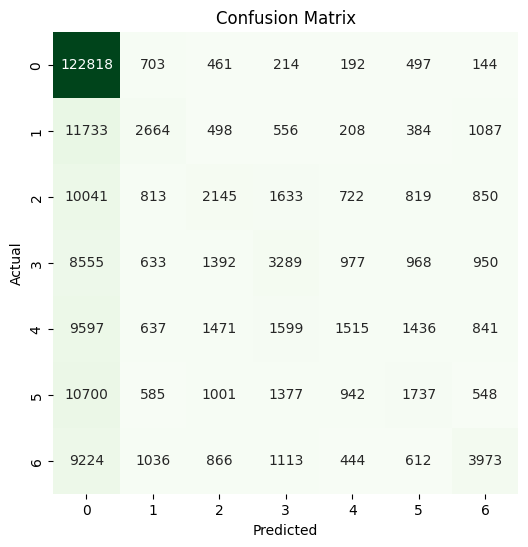

              precision    recall  f1-score   support

           0       0.67      0.98      0.80    125029
           1       0.38      0.16      0.22     17130
           2       0.27      0.13      0.17     17023
           3       0.34      0.20      0.25     16764
           4       0.30      0.09      0.14     17096
           5       0.27      0.10      0.15     16890
           6       0.47      0.23      0.31     17268

    accuracy                           0.61    227200
   macro avg       0.39      0.27      0.29    227200
weighted avg       0.52      0.61      0.53    227200



In [84]:
y_true = np.array(y_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred))